In [1]:
from __future__ import print_function
import os
import argparse
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from data import cfg_mnet, cfg_re50
from layers.functions.prior_box import PriorBox
from utils.nms.py_cpu_nms import py_cpu_nms
import cv2
from models.retinaface import RetinaFace
from utils.box_utils import decode, decode_landm
import time
import matplotlib.pyplot as plt
from torchvision.transforms.functional import crop
from torchvision.transforms.functional import rotate

In [2]:
#parser = argparse.ArgumentParser(description='Retinaface')

#parser.add_argument('-m', '--trained_model', default='./weights/Resnet50_Final.pth',type=str, help='Trained state_dict file path to open')
#parser.add_argument('--network', default='resnet50', help='Backbone network mobile0.25 or resnet50')
#parser.add_argument('--cpu', action="store_true", default=False, help='Use cpu inference')
#parser.add_argument('--confidence_threshold', default=0.02, type=float, help='confidence_threshold')
#parser.add_argument('--top_k', default=5000, type=int, help='top_k')
#parser.add_argument('--nms_threshold', default=0.4, type=float, help='nms_threshold')
#parser.add_argument('--keep_top_k', default=750, type=int, help='keep_top_k')
#parser.add_argument('-s', '--save_image', action="store_true", default=True, help='show detection results')
#parser.add_argument('--vis_thres', default=0.6, type=float, help='visualization_threshold')
#args = parser.parse_args()

In [3]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    #print('Missing keys:{}'.format(len(missing_keys)))
    #print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    #print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True

In [4]:
def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    #print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}

In [5]:
def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
        print("Model loaded to GPU")
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [6]:
def face_select(dets, selec_thresh):
    previous_area = 0
    max_area = 0
    #print("dets", dets)
    prev_coords = np.zeros_like(dets[0])
    coords = np.zeros_like(dets[0])

    for b in dets:
        if b[4] < selec_thresh: # Excludes lower score detections indicating possible background faces
            continue
        
        height = b[3]-b[1] #ymax-ymin
        width = b[2]-b[0] #xmax-xmin
    
        b = list(map(int, b))
        bbox_area = width*height
        #print(len(dets))
        #print("test", bbox_area, previous_area)
        
        if len(dets) == 1: # Only one face present in the picture
            max_area = bbox_area
            coords[:] = b
        else:
            if bbox_area > previous_area:
                previous_area = bbox_area
                prev_coords[:] = b
            else:
                max_area = previous_area
                coords [:] = prev_coords
    face = np.append(coords, max_area)

    return face
    #if tensor is not None:
        #percentage = 10
        #w_margin = 1 + (percentage/100)
        #h_margin = 1 + (percentage/100)
    
        #pre_crop_height = (coords[3]-coords[1]) * h_margin #ymax-ymin
        #pre_crop_width = (coords[2]-coords[0]) * w_margin #xmax-xmin
    
        #pre_crop_coordinates = [int(coords[1]), int(coords[0]), int(pre_crop_height), int(pre_crop_width)]
        #pre_cropped_tensor = crop(tensor, *pre_crop_coordinates)
    
        #print("The maximum area corresponds to the face closer to the camera and is equal to {}.".format(max_area))
        #return face, pre_cropped_tensor
    #else:
        #return face

In [7]:
def detection_model(network="resnet50"):
    if network == "mobile0.25":
        cfg = cfg_mnet
        trained_model = "./weights/mobilenet0.25_Final.pth"
    elif network == "resnet50":
        cfg = cfg_re50
        trained_model = "./weights/Resnet50_Final.pth"
    # net and model
    net = RetinaFace(cfg=cfg, phase = 'test')
    net = load_model(net, trained_model, False)
    net.eval()
    cudnn.benchmark = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu") # Defines the computation device (cuda:0 => GPU)
    net = net.to(device)
    
    return net, cfg, device

In [8]:
def crop_align(img, dets, selec_thresh, net, cfg, device, img_name, save=False):
    '''
    b[0], b[1] is the top left corner of the bounding box
    b[2], b[3] is the lower right corner of the bounding box
    b[4] relates to the the score of the detection
    b[5], b[6] is the left eye
    b[7], b[8] is the right eye
    b[9], b[10] is the nose
    b[11], b[12] is the left of the mouth
    b[13], b[14] is the right of the mouth
    '''
    
    #img_raw = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    face_coords = face_select(dets, selec_thresh)
    face_coords = list(map(int, face_coords)) # Coordinates must be integers
    
    print("face coords------------", face_coords)
    
    # -------------------- Rotation Stage ---------------------
    left_eye = (face_coords[5], face_coords[6]) # Components: (x, y)
    right_eye = (face_coords[7], face_coords[8])
    if left_eye[1] > right_eye[1]:               # Right eye is higher
        # Clock-wise rotation
        aux_point = (right_eye[0], left_eye[1])
        a = right_eye[0] - left_eye[0]
        b = right_eye[1] - aux_point[1]
        
        #cv2.circle(img_raw, left_eye, 10, (0, 255, 0), 4)
        #cv2.circle(img_raw, right_eye, 10, (0, 255, 0), 4)
        #cv2.circle(img_raw, aux_point, 10, (0, 255, 0), 4)
        
        #cv2.line(img_raw, left_eye, right_eye, (23, 23, 23), 2)
        #cv2.line(img_raw, aux_point, right_eye, (23, 23, 23), 2)
        #cv2.line(img_raw, left_eye, aux_point, (23, 23, 23), 2)
        #plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)) 
        
        theta = np.rad2deg(np.arctan(b/a)) # Angle of rotation in degrees
        print("Right eye is higher, therefore, a clock-wise rotation of {} is applied".format(-theta))
        rotated_tensor = rotate(img.squeeze(), angle=theta, center=right_eye)

    else:                                        # Left eye is higher
        # Counter clock-wise rotation
        aux_point = (left_eye[0], right_eye[1])
        a = right_eye[0] - left_eye[0]
        b = left_eye[1] - aux_point[1]
        
        #cv2.circle(img_raw, left_eye, 10, (0, 255, 0), 4)
        #cv2.circle(img_raw, right_eye, 10, (0, 255, 0), 4)
        #cv2.circle(img_raw, aux_point, 10, (0, 255, 0), 4)
        
        #plt.imshow(img_raw)
        
        theta = np.rad2deg(np.arctan(b/a))
        print("Left eye is higher, therefore, a clock-wise rotation of {} degrees is applied".format(-theta))
        rotated_tensor = rotate(img.squeeze(), angle=-theta, center=left_eye)
        
    #plt.imshow(rotated_tensor.squeeze().permute(1, 2, 0).cpu().numpy().astype(int))
    
    # -------------------- New Bounding Box computing ---------------------
    # The image is rotated, a new bbox must be generated. 
    
    # TBD: optimization by performing a preliminary crop in order to try and isolate only the relevant face
    
    loc, conf, _ = net(rotated_tensor.unsqueeze(0))  # Forward pass that gives the results <--------------
    
    im_height = rotated_tensor.shape[1]
    im_width = rotated_tensor.shape[2]
    
    resize = 1
    new_scale = torch.Tensor([rotated_tensor.shape[2], rotated_tensor.shape[1], rotated_tensor.shape[2], rotated_tensor.shape[1]])
    new_scale = new_scale.to(device)
    
    new_priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    new_priors = new_priorbox.forward()
    new_priors = new_priors.to(device)
    new_prior_data = new_priors.data
    
    new_boxes = decode(loc.data.squeeze(0), new_prior_data, cfg['variance'])
    new_boxes = new_boxes * new_scale / resize
    new_boxes = new_boxes.cpu().numpy() # Tensor is moved to CPU (numpy doesn't support GPU)
    new_scores = conf.squeeze(0).data.cpu().numpy()[:, 1]

    # Score's threshold
    confidence_threshold = 0.02 # Default value
    inds = np.where(new_scores > confidence_threshold)[0]
    new_boxes = new_boxes[inds]
    new_scores = new_scores[inds]

    # keep top-K before NMS
    top_k = 500 # Default value
    order = new_scores.argsort()[::-1][:top_k] # Extracts the indexes relating to the top scores
    new_boxes = new_boxes[order] # Array [300, 4] where in each line are the coordinates
    new_scores = new_scores[order] # Array [1, 300]
    
    # do NMS
    nms_threshold = 0.4 # Default value
    new_dets = np.hstack((new_boxes, new_scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(new_dets, nms_threshold)
    new_dets = new_dets[keep, :]

    # keep top-K faster NMS
    #keep_top_k = 500 # Default value
    #new_dets = new_dets[:keep_top_k, :]
    
    #rotated_bbox = new_dets[0]
    rotated_bbox = face_select(new_dets, selec_thresh)
    #print("rotated_bbox 1", rotated_bbox)
    rotated_bbox = list(map(int, rotated_bbox))
    #print("rotated_bbox 2", rotated_bbox)
    
    
    # -------------------- Cropping Stage ---------------------
    crop_height = rotated_bbox[3]-rotated_bbox[1] #ymax-ymin
    crop_width = rotated_bbox[2]-rotated_bbox[0] #xmax-xZmin
    crop_coordinates = (rotated_bbox[1], rotated_bbox[0], crop_height, crop_width)
    cropped_tensor = crop(rotated_tensor, *crop_coordinates)
    
    image_array = cropped_tensor.permute(1,2,0).cpu().numpy()
    
    print(image_array)
    # Convert the numpy array to BGR format (required by OpenCV)
    cropped_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    
    if save == True and img_name != None:
        new_name = "cropped_" + img_name
        if not os.path.exists("cropped/"):
            print("Result's directory created!")
            os.makedirs("cropped/")
        new_name = "cropped/" + new_name
        cv2.imwrite(new_name, cropped_image)
    return cropped_tensor

In [9]:
# https://github.com/biubug6/Pytorch_Retinaface/
def face_detection(net, cfg, device, img, img_name):
    save_image = False
    torch.set_grad_enabled(False)
    
    resize = 1

    # Testing stage
    
    im_height = img.shape[0]
    im_width = img.shape[1]
    print(im_height, im_width)
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])

    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    
    img = img.to(device)
    scale = scale.to(device)
    
    #print("scale", scale)
    #print("shape", img.shape)
    #print("type", img.type)

    if img.is_cuda: print("Tensor in gpu")
        
    tic = time.time()
    loc, conf, landms = net(img)  # Forward pass that gives the results <--------------
    #print(loc)
    #print(loc.type)
    #print(loc.shape)
    
    print(loc)
    print(" ")
    print(conf)
    print(" ")
    print(landms)
    
    print('Forward time: {:.4f}'.format(time.time() - tic))
        
    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data
    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    
    
    #print("scale ", scale)
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy() # Tensor is moved to CPU (numpy doesn't support GPU)
    scores = conf.squeeze(0).data.cpu().numpy()[:, 0]
    
    #print(" ")
    #print("conf ", conf)
    #print("conf.squeeze(0) ", conf.squeeze(0))
    #print("conf.squeeze(0).data ", conf.squeeze(0).data)
    #print("conf.squeeze(0).data.cpu().numpy() ", conf.squeeze(0).data.cpu().numpy())
    #print("conf.squeeze(0).data.cpu().numpy()[:, 1] ", conf.squeeze(0).data.cpu().numpy()[:, 1])
    #print("scores ", scores)
    #print(" ")
    
    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
    scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                            img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                            img.shape[3], img.shape[2]])
    
    scale1 = scale1.to(device)
    landms = landms * scale1 / resize
    landms = landms.cpu().numpy()
    
    
    # Score's threshold
    confidence_threshold = 0.02 # Default value
    inds = np.where(scores > confidence_threshold)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]
    print(" -----------------")
    print(" -----------------")
    #print(boxes)
    print(" ")
    #print(scores)
    print(" ")
    #print(landms)
    
    # keep top-K before NMS
    top_k = 500 # Default value
    order = scores.argsort()[::-1][:top_k] # Extracts the indexes relating to the top scores
    boxes = boxes[order] # Array [300, 4] where in each line are the coordinates
    landms = landms[order] # Array [300, 10]
    scores = scores[order] # Array [1, 300]
    
    # do NMS
    nms_threshold = 0.4 # Default value
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, nms_threshold)
    dets = dets[keep, :]
    landms = landms[keep]

    # keep top-K faster NMS
    #keep_top_k = 750 # Default value
    #dets = dets[:keep_top_k, :]
    #landms = landms[:keep_top_k, :]
        
    dets = np.concatenate((dets, landms), axis=1)
    
    cropped = crop_align(img, dets, 0.1, net, cfg, device, img_name, save=False)
    
    #if cropped.is_cuda: print("tensor in GPU")

        # show image
        #vis_thres = 0.6
        #for b in dets:
            #if b[4] < vis_thres:
                #continue
            #text = "{:.4f}".format(b[4])
            #b = list(map(int, b))
            #cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
            #cx = b[0]
            #cy = b[1] + 12
            #cv2.circle(img_raw, (0, 0), 10, (0, 255, 0), 4)
            #cv2.circle(img_raw, (b[0], b[1]), 1, (255, 0, 255), 4)
            #cv2.circle(img_raw, (b[2], b[3]), 1, (255, 0, 255), 4)
            #cv2.putText(img_raw, text, (cx, cy),
                        #cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

            # landms
            #cv2.circle(img_raw, (b[5], b[6]), 1, (0, 0, 255), 4)
            #cv2.circle(img_raw, (b[7], b[8]), 1, (0, 255, 255), 4)
            #cv2.circle(img_raw, (b[9], b[10]), 1, (255, 0, 255), 4)
            #cv2.circle(img_raw, (b[11], b[12]), 1, (0, 255, 0), 4)
            #cv2.circle(img_raw, (b[13], b[14]), 1, (255, 0, 0), 4)
        
    
    #plt.imshow(cropped.permute(1, 2, 0).cpu().numpy().astype(int))
    return cropped

Number of images:  78


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading pretrained model from ./weights/Resnet50_Final.pth
Model loaded to GPU
112 112
Tensor in gpu
tensor([[[ 1.1963,  2.3888, -0.8869, -0.2896],
         [ 1.1693,  2.0621, -1.4358, -1.0203],
         [-0.9498,  2.6298,  0.5487, -0.2042],
         ...,
         [-0.1732, -0.5490, -1.6340, -1.6690],
         [-0.3664, -0.6836, -2.2347, -1.5411],
         [-0.0574, -0.2744, -2.4911, -1.5650]]], device='cuda:0')
 
tensor([[[9.9960e-01, 3.9940e-04],
         [9.9982e-01, 1.7757e-04],
         [9.9947e-01, 5.2790e-04],
         ...,
         [1.0000e+00, 4.2273e-06],
         [9.9998e-01, 2.3115e-05],
         [1.0000e+00, 2.7331e-07]]], device='cuda:0')
 
tensor([[[-1.2614e+00, -5.0937e-03,  2.0895e+00,  ...,  5.1686e+00,
           1.2979e+00,  5.2394e+00],
         [-1.1246e+00,  1.6540e-01,  1.2166e+00,  ...,  3.5621e+00,
           7.3441e-01,  3.3913e+00],
         [-3.9785e+00, -1.2237e-01,  2.0714e-01,  ...,  4.8808e+00,
          -6.2515e-01,  5.0918e+00],
         ...,
        

/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


tensor([[[ 1.3269,  2.7287, -1.2621,  0.5111],
         [ 1.9187,  3.5075, -1.4751,  0.4964],
         [-0.5556,  3.0037,  0.0755,  0.1558],
         ...,
         [ 0.0985, -0.1616, -0.7282, -0.8513],
         [-0.0600, -0.2284, -1.1350, -0.7087],
         [ 0.1896,  0.0442, -1.4359, -1.1950]]], device='cuda:0')
 
tensor([[[9.9975e-01, 2.4991e-04],
         [9.9988e-01, 1.2444e-04],
         [9.9965e-01, 3.5464e-04],
         ...,
         [9.9959e-01, 4.1171e-04],
         [9.9982e-01, 1.8407e-04],
         [9.9996e-01, 3.9547e-05]]], device='cuda:0')
 
tensor([[[-0.9900,  1.3179,  2.5906,  ...,  7.6662,  2.0157,  7.7338],
         [ 0.1171,  2.1091,  2.7868,  ...,  7.0019,  2.5540,  6.5890],
         [-3.2978,  1.4366,  1.2402,  ...,  7.2204,  0.2664,  7.5848],
         ...,
         [ 0.0631, -0.4763,  0.5074,  ...,  0.4700,  0.6776,  0.5033],
         [-0.4437, -0.4081,  0.8019,  ...,  0.4447,  0.5727,  0.2183],
         [ 0.0730, -0.3752,  0.9260,  ...,  0.7862,  0.9240,  0.7447]

error: OpenCV(4.7.0) /opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


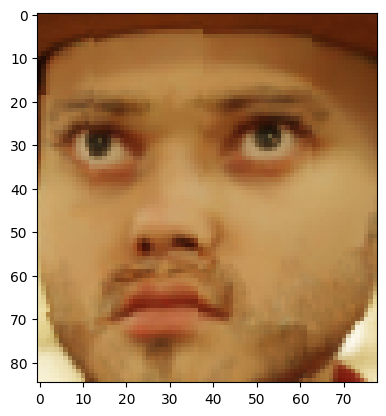

In [10]:
# Testing folder
test_folder = "test/"
files = os.listdir(test_folder)
images = [file_name for file_name in files if not file_name.startswith('.')]
num_images = len(images)

print("Number of images: ", num_images)

t_tic = time.time()

net, cfg, device = detection_model()

#image_path = "test/5.jpg"
#img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
#img_raw_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
#img = np.float32(img_raw_rgb)

#cropped_face_tensor = face_detection(net, cfg, device, img)

for i, img_name in enumerate(images):
    image_path = os.path.join(test_folder, img_name)
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_raw_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    img = np.float32(img_raw_rgb)
    
    cropped_face_tensor = face_detection(net, cfg, device, img, img_name)
    plt.imshow(cropped_face_tensor.permute(1, 2, 0).cpu().numpy().astype(int))
    
    if cropped_face_tensor.is_cuda: print("Tensor in gpu")
print('Total time: {:.4f}'.format(time.time() - t_tic)) 